## Download Data
1. Data https://www.kaggle.com/datasets/mishra5001/credit-card

## Import library

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
%matplotlib inline

## Read data & EDA

In [3]:
data = pd.read_csv('/Users/chengchanglei/Library/CloudStorage/GoogleDrive-qscft88@gmail.com/我的雲端硬碟/國立政治大學/碩二/碩二上學期/財務工程與數學/cardfraud/application_data.csv')
pd.set_option('display.max_columns', None)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

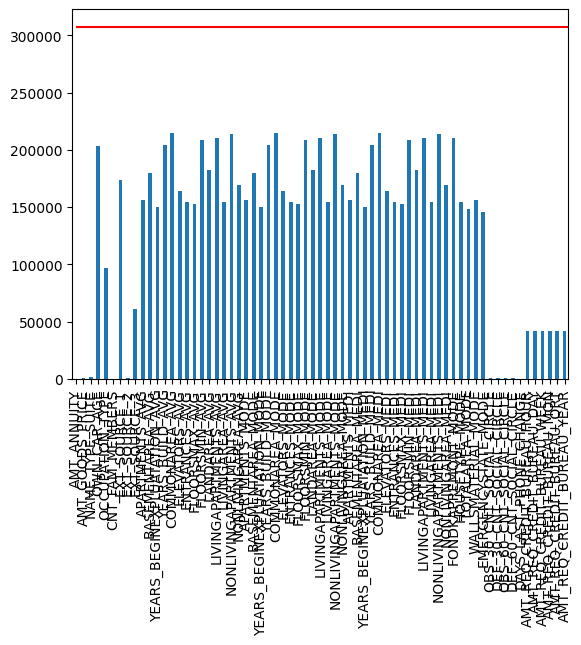

In [4]:
# 透過視覺化確認資料null的狀況
plt.figure()
plt.tick_params(colors='black', which='both')
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')
# data[data['TARGET'] == 1].isna().sum()[(data[data['TARGET'] == 1].isna().sum()>0)].plot(kind='bar', color = 'gray')
plt.hlines(y = len(data), xmin = 0, xmax = len(data.columns), color = 'red')
# plt.hlines(y = len(data[data['TARGET'] == 1]), xmin = 0, xmax = len(data.columns), color = 'purple')
plt.tight_layout

In [4]:
defaulters = data[data.TARGET == 1]
nondefaulters = data[data.TARGET == 0]

def biplot(data, var, label_rotation):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))
    s1 = sns.barplot(ax=ax1, x=defaulters[var].value_counts().index, data=defaulters,
                        y=100. * defaulters[var].value_counts(normalize=True))
    if (label_rotation):
        s1.set_xticklabels(s1.get_xticklabels(), rotation=90, fontsize=12)
    ax1.set_title('Distribution of ' + '%s' % var + ' - Defaulters', fontsize=15)
    ax1.set_xlabel('%s' % var, fontsize=15)
    ax1.set_ylabel("% of Loans", fontsize=15)

    s2 = sns.barplot(ax=ax2, x=nondefaulters[var].value_counts().index, data=nondefaulters,
                        y=100. * nondefaulters[var].value_counts(normalize=True))
    if (label_rotation):
        s2.set_xticklabels(s2.get_xticklabels(), rotation=90, fontsize=12)
    ax2.set_xlabel('%s' % var, fontsize=15)
    ax2.set_ylabel("% of Loans", fontsize=15)
    ax2.set_title('Distribution of ' + '%s' % var + ' - Non-Defaulters', fontsize=15)
    plt.tight_layout()

## Create X Y data

In [5]:
Y = data['TARGET']
X = data.drop(columns = ['TARGET','SK_ID_CURR'])

## Data Preprocessing(Null values...)

In [6]:
np.where(X.isna().sum()>30751)

(array([ 19,  26,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88, 114,
        115, 116, 117, 118, 119]),)

In [7]:
X.columns[[19,  26,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88, 114,
        115, 116, 117, 118, 119]]

Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMEN

In [8]:
X.drop(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'DAYS_EMPLOYED',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1, inplace=True)

In [9]:
def mode_impute(df,col):
    return df[col].fillna(df[col].mode()[0])
def integer_impute(df,col):
    return df[col].fillna(df[col].mode()[0])

obj_list = X.select_dtypes('object').columns
X[obj_list].isnull().sum()
X['NAME_TYPE_SUITE'] = mode_impute(X, 'NAME_TYPE_SUITE')

X['CNT_FAM_MEMBERS'] = integer_impute(X, 'CNT_FAM_MEMBERS')
X['DAYS_LAST_PHONE_CHANGE'] = integer_impute(X, 'DAYS_LAST_PHONE_CHANGE')

In [10]:
float_col = X.select_dtypes('float').columns
for k in float_col:
    X[k] = X[k].interpolate(method ='linear', limit_direction ='forward')

In [11]:
X['CODE_GENDER'].replace('XNA', 'M', inplace=True)

X['ORGANIZATION_TYPE'].replace('XNA', 'Business Entity Type 3', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3'], 'Business Entity Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Trade: type 1', 'Trade: type 2', 'Trade: type 3','Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'], 'Trade Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Industry: type 1', 'Industry: type 2', 'Industry: type 3','Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 
                                'Industry: type 8', 'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Industry: type 13'], 'Industry Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Transport: type 1', 'Transport: type 2', 'Transport: type 3','Transport: type 4'], 'Transport Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Hotel', 'Electricity', 'Insurance', 'Telecom', 'Emergency', 'Advertising', 'Realtor', 'Culture', 'Mobile', 'Legal Services', 'Cleaning', 'Religion', 'Security', 'Housing',
                                'Military', 'Bank', 'Agriculture', 'Police', 'Postal', 'Security Ministries', 'Restaurant', 'Services', 'University'], 'Other', inplace=True)

X['NAME_HOUSING_TYPE'].replace(['Co-op apartment', 'Office apartment', 'Rented apartment'], 'Other', inplace=True)

X['NAME_TYPE_SUITE'].replace(['Group of people', 'Children', 'Other_A', 'Other_B'], 'Other', inplace=True)
X['NAME_TYPE_SUITE'].replace('Spouse, partner', 'Spouse partner', inplace=True)

X['NAME_INCOME_TYPE'].replace(['Unemployed', 'Student', 'Businessman', 'Maternity leave'], 'Working', inplace=True)

X['NAME_FAMILY_STATUS'].replace(['Unknown'], 'Married', inplace=True)

## 刪除過多一樣的變數

In [12]:
X.drop(['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMP_PHONE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_7','FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',  
        'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 
        'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START', 
        'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'REGION_POPULATION_RELATIVE', 'CNT_CHILDREN'], axis = 1, inplace=True)

In [13]:
# plt.figure(figsize=(10,5))
# data['FLAG_MOBIL'].value_counts().plot(kind='pie', autopct='%1.2f%%')
# plt.ylabel('')
# plt.title('')

In [14]:
X_discrete = X[['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_EMAIL', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE','NAME_FAMILY_STATUS',
       'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','ORGANIZATION_TYPE', 'NAME_HOUSING_TYPE',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8']]
X_continuous = X.drop(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_EMAIL', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE','NAME_FAMILY_STATUS',
       'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','ORGANIZATION_TYPE', 'NAME_HOUSING_TYPE',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8'], axis=1)

In [15]:
X_prep = pd.concat([X_continuous, X_discrete], axis = 1)

In [16]:
X_prep[['DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']] = np.abs(X_prep[['DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']])

In [17]:
X_conti_col = X_continuous.columns
X_categ_col = X_discrete.columns

## Frequency encoding

In [18]:
X_prep['NAME_CONTRACT_TYPE'].replace({'Cash loans':278232, 
                                    'Revolving loans':29279}, inplace=True)
X_prep['CODE_GENDER'].replace({'F':202448, 'M':105063}, inplace=True)
X_prep['FLAG_OWN_CAR'].replace({'N':202924, 'Y':104587}, inplace=True)
X_prep['FLAG_OWN_REALTY'].replace({'Y':213312, 'N':94199}, inplace=True)
X_prep['FLAG_EMAIL'].replace({0:290069, 1:17442}, inplace=True)
X_prep['NAME_TYPE_SUITE'].replace({'Unaccompanied':249818, 
                                    'Family':40149, 
                                    'Spouse partner':11370, 
                                    'Other':6174}, inplace=True)
X_prep['NAME_INCOME_TYPE'].replace({'Working':158829, 
                                    'Commercial associate':71617, 
                                    'Pensioner':55362, 
                                    'State servant':21703}, inplace=True)
X_prep['NAME_EDUCATION_TYPE'].replace({'Secondary / secondary special':218391, 
                                        'Higher education':74863, 
                                        'Incomplete higher':10277, 
                                        'Lower secondary':3816, 
                                        'Academic degree':164}, inplace=True)
X_prep['FLAG_WORK_PHONE'].replace({1:252125, 0:55386}, inplace=True)
X_prep['FLAG_PHONE'].replace({0:221080, 1:86431}, inplace=True)
X_prep['REG_REGION_NOT_LIVE_REGION'].replace({0:302854, 1:4657}, inplace=True)
X_prep['REG_REGION_NOT_WORK_REGION'].replace({0:291899, 1:15612}, inplace=True)
X_prep['ORGANIZATION_TYPE'].replace({'Business Entity Type':139903,
                                    'Other':47489,
                                    'Self-employed':38412,
                                    'Trade Type':14315,
                                    'Industry Type':14311,
                                    'Medicine':11193,
                                    'Government':10404,
                                    'Transport Type':8990,
                                    'School':8893,
                                    'Kindergarten':6880,
                                    'Construction':6721}, inplace=True)
X_prep['NAME_HOUSING_TYPE'].replace({'House / apartment':272868,
                                    'With parents':14840,
                                    'Municipal apartment':11183,
                                    'Other':8620}, inplace=True)
X_prep['NAME_FAMILY_STATUS'].replace({'Married':196434,
                                    'Single / not married':45444,
                                    'Civil marriage':29775,
                                    'Separated':19770,
                                    'Widow':16088}, inplace=True)                                    
X_prep['REG_CITY_NOT_WORK_CITY'].replace({0:236644, 1:70867}, inplace=True)
X_prep['LIVE_CITY_NOT_WORK_CITY'].replace({0:252296, 1:55215}, inplace=True)
X_prep['LIVE_REGION_NOT_WORK_REGION'].replace({0:295008, 1:12503}, inplace=True)
X_prep['REG_CITY_NOT_LIVE_CITY'].replace({0:283472, 1:24039}, inplace=True)
X_prep['FLAG_DOCUMENT_3'].replace({0:89171, 1:218340}, inplace=True)
X_prep['FLAG_DOCUMENT_6'].replace({0:280433, 1:27078}, inplace=True)
X_prep['FLAG_DOCUMENT_8'].replace({0:282487, 1:25024}, inplace=True)

In [19]:
X_prep = X_prep.astype('int')
Y = Y.astype('int')

In [20]:
def checkVIF(df):
    df['constant'] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name, 'VIF':VIF_list})
    #remove VIF>10
    dropcol = list(VIF[VIF['VIF']>10]['feature'])
    # dropcol.append('constant')
    for i in dropcol:
        del df[i]
    return df

In [21]:
X_prep_VIF = checkVIF(X_prep)
X_prep_VIF

,AMT_INCOME_TOTAL,AMT_ANNUITY,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMAIL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,ORGANIZATION_TYPE,NAME_HOUSING_TYPE,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,202500,24700,9461,3648,2120,1,1134,278232,105063,202924,213312,290069,249818,158829,45444,218391,55386,86431,302854,291899,139903,272868,236644,252296,295008,283472,218340,280433,282487
1,270000,35698,16765,1186,291,2,828,278232,202448,202924,94199,290069,40149,21703,196434,74863,55386,86431,302854,291899,8893,272868,236644,252296,295008,283472,218340,280433,282487
2,67500,6750,19046,4260,2531,1,815,29279,105063,104587,213312,290069,249818,158829,45444,218391,252125,86431,302854,291899,10404,272868,236644,252296,295008,283472,89171,280433,282487
3,135000,29686,19005,9833,2437,2,617,278232,202448,202924,213312,290069,249818,158829,29775,218391,55386,221080,302854,291899,139903,272868,236644,252296,295008,283472,218340,280433,282487
4,121500,21865,19932,4311,3458,1,1106,278232,105063,202924,213312,290069,249818,158829,45444,218391,55386,221080,302854,291899,47489,272868,70867,55215,295008,283472,89171,280433,25024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,157500,27558,9327,8456,1982,1,273,278232,105063,202924,94199,290069,249818,158829,19770,218391,55386,221080,302854,291899,47489,14840,236644,252296,295008,283472,89171,280433,25024
307507,72000,12001,20775,4388,4090,1,0,278232,202448,202924,213312,290069,249818,55362,16088,218391,55386,86431,302854,291899,139903,272868,236644,252296,295008,283472,218340,280433,282487
307508,153000,29979,14966,6737,5150,1,1909,278232,202448,202924,213312,17442,249818,158829,19770,74863,55386,221080,302854,291899,8893,272868,70867,55215,295008,283472,218340,280433,282487
307509,171000,20205,11961,2562,931,2,322,278232,202448,202924,213312,290069,249818,71617,196434,218391,55386,221080,302854,291899,139903,272868,70867,252296,295008,24039,218340,280433,282487


In [22]:
X_prep_continuous = X_prep_VIF[['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE']]
X_prep_discrete = X_prep_VIF.drop(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'],axis = 1)
conti_col = X_prep_continuous.columns
categ_col = X_prep_discrete.columns

## 資料平衡標準化

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X_prep_VIF, Ｙ, stratify=Y, test_size= 0.3, random_state=1)

In [24]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

0    197880
1     17377
Name: TARGET, dtype: int64
0    84806
1     7448
Name: TARGET, dtype: int64


In [25]:
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True); x_test.reset_index(drop=True, inplace=True); y_test.reset_index(drop=True, inplace=True)

In [26]:
# X_train_fin.reset_index(drop=True, inplace=True); Y_train_fin.reset_index(drop=True, inplace=True); X_val.reset_index(drop=True, inplace=True); Y_val.reset_index(drop=True, inplace=True); 

In [27]:
oversample = SMOTE(sampling_strategy = 'all', random_state = 1)
X_train_bal, Y_train_bal = oversample.fit_resample(x_train, y_train)

### 訓練集標準化

In [76]:
scalor = StandardScaler()
x_scaled = scalor.fit_transform(X_train_bal[conti_col])
X_train = pd.DataFrame(columns = conti_col, data = x_scaled)
X_train[categ_col] = np.log10(X_train_bal[categ_col])
X_train
Y_train = Y_train_bal

In [77]:
Y_train.value_counts()

0    197880
1    197880
Name: TARGET, dtype: int64

### 測試集標準化

In [78]:
x_test_scaled = scalor.transform(x_test[conti_col])
X_test = pd.DataFrame(columns = conti_col, data = x_test_scaled)
X_test[categ_col] = np.log10(x_test[categ_col])
Y_test = y_test

In [92]:
X_test

,AMT_INCOME_TOTAL,AMT_ANNUITY,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMAIL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,ORGANIZATION_TYPE,NAME_HOUSING_TYPE,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,0.107754,-0.145454,-1.341921,-0.675745,-0.131981,-1.227792,-0.891750,5.444407,5.306313,5.307333,5.329015,5.462501,5.397624,5.200930,4.657477,5.339235,4.7434,5.344549,5.481233,5.465233,4.584467,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998
1,-0.253773,-0.708858,0.026042,-0.704452,1.049679,-1.227792,1.106263,5.444407,5.306313,5.307333,4.974046,5.462501,5.397624,5.200930,4.657477,5.339235,4.7434,5.344549,5.481233,5.465233,4.155791,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998
2,-0.210390,-0.249679,2.059185,-0.702268,1.171748,-0.051651,-0.796734,5.444407,5.021450,5.307333,5.329015,5.462501,4.603675,4.743212,5.293217,4.874267,4.7434,5.344549,5.481233,5.465233,5.145827,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998
3,0.700659,1.046174,-1.059546,-0.216439,-0.666389,-0.051651,-0.811455,5.444407,5.306313,5.019478,5.329015,5.462501,5.397624,4.855016,5.293217,4.874267,4.7434,4.936670,5.481233,5.465233,4.676593,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998
4,-0.022396,0.321109,-1.194911,0.104951,-0.320762,1.124490,-1.192858,5.444407,5.306313,5.307333,5.329015,5.462501,5.397624,5.200930,5.293217,4.874267,4.7434,5.344549,5.481233,5.465233,4.155670,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,-0.355001,-0.531575,1.702821,0.144266,1.048259,-1.227792,-0.016532,5.444407,5.306313,5.307333,5.329015,5.462501,5.397624,4.743212,4.657477,5.339235,4.7434,5.344549,5.481233,5.465233,5.145827,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998
92250,0.006527,-0.894613,-1.032134,-1.077014,0.637340,-1.227792,1.029982,5.444407,5.306313,5.307333,5.329015,5.462501,5.397624,4.855016,4.657477,4.874267,4.7434,5.344549,5.481233,5.465233,4.676593,5.435953,4.850444,4.742057,5.469834,5.45251,5.339133,5.447829,5.450998
92251,-0.326078,-0.244394,0.275182,1.206724,-1.899147,-0.051651,0.082498,5.444407,5.306313,5.019478,5.329015,5.462501,4.055760,5.200930,5.293217,5.339235,4.7434,5.344549,5.481233,5.465233,3.827434,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998
92252,-0.167006,-1.015626,-0.623855,-0.822087,1.023420,1.124490,0.765008,5.444407,5.306313,5.019478,5.329015,4.241596,5.397624,5.200930,5.293217,5.339235,4.7434,5.344549,5.481233,5.465233,4.048947,5.435953,5.374095,5.401910,5.469834,5.45251,5.339133,5.447829,5.450998


In [79]:
Y_test.value_counts()

0    84806
1     7448
Name: TARGET, dtype: int64

## Cross Validation

In [80]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
model=LogisticRegression() 
results = cross_validate(estimator=model,
                            X=X_train,
                            y=Y_train,
                            cv=cv,
                            scoring=['accuracy', 'recall', 'precision'])
results['test_recall']

array([0.63210026, 0.62613705, 0.62765312, 0.62497473, 0.62320598,
       0.62795634, 0.6264908 , 0.62416616, 0.62168991, 0.62674348])

## Logistic Regression

In [81]:
import copy
def Logit_model(X_train, y_train, X_test, y_test, verbose=True):
    X_train_bal, Y_train_bal = SMOTE(sampling_strategy='minority', random_state=1).fit_resample(X_train, y_train)
    X_train, y_train = X_train_bal, Y_train_bal
    included = list(X_train.columns)
    bic=[]
    while True:
        changed=False
        model_stepwise=sm.Logit(y_train ,sm.add_constant(pd.DataFrame(X_train[included]))).fit()
        bic = model_stepwise.bic
        bic_new = {}
        for i in included:
            new_included = copy.deepcopy(included)
            new_included.remove(i)
            model_stepwise_new = sm.Logit(y_train, sm.add_constant(pd.DataFrame(X_train[new_included]))).fit()
            bic_new[i]=model_stepwise_new.bic
        if len(included) <= 10:
            break
        if min(bic_new.values()) < bic:
            changed = True
            included.remove(min(bic_new,key = bic_new.get))
            if verbose:
                print('Drop {} with BIC decrease by {}'.format(min(bic_new, key = bic_new.get), (bic-min(bic_new.values()))))
        if not changed:
            break

    #Logistic Regression
    x_logistic=sm.add_constant(X_train[included])
    logistic=sm.Logit(y_train,x_logistic)
    logistic_model=logistic.fit()
    print(logistic_model.summary())

    #for train_data
    # plot confusion matirx
    print("Logitrain accuracy")
    print(metrics.confusion_matrix(y_train, list(map(round,logistic_model.predict(sm.add_constant(X_train[included]))))))
    print('Accuracy = ',metrics.accuracy_score(y_train, list(map(round,logistic_model.predict(sm.add_constant(X_train[included]))))))
    print('Precision = ', metrics.precision_score(y_train,list(map(round,logistic_model.predict(sm.add_constant(X_train[included]))))))
    print('Recall = ',metrics.recall_score(y_train,list(map(round,logistic_model.predict(sm.add_constant(X_train[included]))))))
    print('F1-score = ', metrics.f1_score(y_train, list(map(round,logistic_model.predict(sm.add_constant(X_train[included]))))))

    #for vad_data
    # plot confusion matirx
    print("Logitest accuracy")
    print(metrics.confusion_matrix(y_test ,list(map(round,logistic_model.predict(sm.add_constant(X_test[included]))))))
    print('Accuracy = ',metrics.accuracy_score(y_test, list(map(round,logistic_model.predict(sm.add_constant(X_test[included]))))))
    print('Precision = ', metrics.precision_score(y_test,list(map(round,logistic_model.predict(sm.add_constant(X_test[included]))))))
    print('Recall = ',metrics.recall_score(y_test,list(map(round,logistic_model.predict(sm.add_constant(X_test[included]))))))
    print('F1-score = ', metrics.f1_score(y_test, list(map(round,logistic_model.predict(sm.add_constant(X_test[included]))))))
    return included

In [117]:
included = Logit_model(X_train, Y_train, X_test, Y_test, True)
included

Optimization terminated successfully.
         Current function value: 0.638058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640759
  

['AMT_ANNUITY',
 'DAYS_BIRTH',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_EMAIL',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REG_REGION_NOT_LIVE_REGION',
 'ORGANIZATION_TYPE',
 'NAME_HOUSING_TYPE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8']

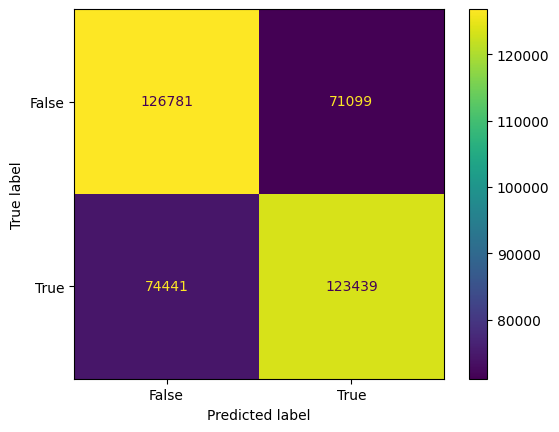

Accuracy =  0.632251869820093
Precision =  0.6345238462408372
Recall =  0.6238073579947443
F1-score =  0.6291199690126346
RMSE =  0.6064224024390154


In [83]:
logistic_regression = LogisticRegression(penalty='l2')
logistic_regression = logistic_regression.fit(X_train, Y_train)

y_predict = logistic_regression.predict(X_train)

# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_train, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='black', which='both')
plt.show() 

print('Accuracy = ',metrics.accuracy_score(Y_train, y_predict))
print('Precision = ', metrics.precision_score(Y_train, y_predict))
print('Recall = ',metrics.recall_score(Y_train, y_predict))
print('F1-score = ', metrics.f1_score(Y_train, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_train, y_predict)))

## Decision Tree

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.428 total time=   1.2s
[CV 2/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.424 total time=   1.1s
[CV 3/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.432 total time=   1.1s
[CV 4/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.421 total time=   1.1s
[CV 5/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.429 total time=   1.1s
[CV 6/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.435 total time=   1.1s
[CV 7/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.424 total time=   1.1s
[CV 8/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.428 total time=   1.2s
[CV 9/10] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.434 total time=   1.2s
[CV 10/10] END max_depth=3, min_sampl

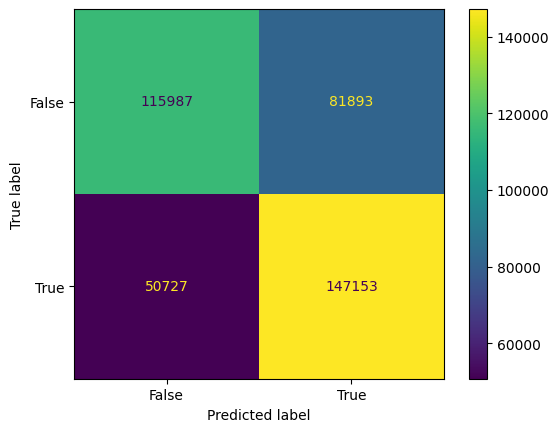

Accuracy =  0.6648979179300586
Precision =  0.6424604664565197
Recall =  0.7436476652516677
F1-score =  0.6893606854583698


In [84]:
parameter = {'max_depth':[3, 4, 5, 6], 'min_samples_leaf':[2, 3, 5], 'min_samples_split':[2, 3, 5]}
grid_result = GridSearchCV(DecisionTreeClassifier(), param_grid = parameter, cv = cv, verbose=3, scoring='recall')
grid_result.fit(X_train[included], Y_train)
best_para = grid_result.best_params_

dc = DecisionTreeClassifier(max_depth = best_para['max_depth'], min_samples_leaf = best_para['min_samples_leaf'], min_samples_split = best_para['min_samples_split'])
dc = dc.fit(X_train[included], Y_train)
y_pred_grid = dc.predict(X_train[included])

confusion_matrix = metrics.confusion_matrix(Y_train, y_pred_grid)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='black', which='both')
plt.show()


print('Accuracy = ',metrics.accuracy_score(Y_train, y_pred_grid))
print('Precision = ', metrics.precision_score(Y_train, y_pred_grid))
print('Recall = ',metrics.recall_score(Y_train, y_pred_grid))
print('F1-score = ', metrics.f1_score(Y_train, y_pred_grid))

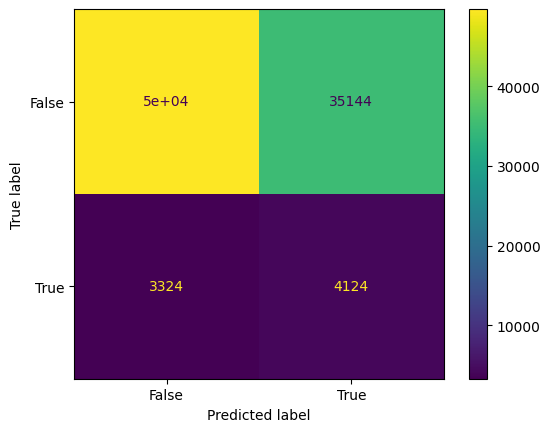

Accuracy =  0.5830207904264314
Precision =  0.10502190078435367
Recall =  0.5537056928034372
F1-score =  0.17655621200445243
RMSE =  0.6457392736806153


In [86]:
# make prediction
y_predict = dc.predict(X_test[included])
# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='black', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
print('Precision = ', metrics.precision_score(Y_test, y_predict))
print('Recall = ',metrics.recall_score(Y_test, y_predict))
print('F1-score = ', metrics.f1_score(Y_test, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_test, y_predict)))

<AxesSubplot:ylabel='feature'>

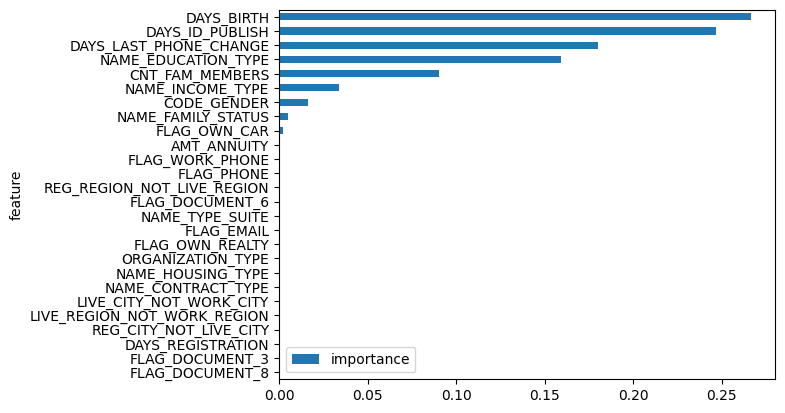

In [87]:
imp = dc.feature_importances_
feature = dc.feature_names_in_
df_imp = pd.DataFrame()
df_imp['feature'] = feature
df_imp['importance'] = imp
df_imp.set_index('feature', inplace=True)
df_imp.sort_values(ascending=True, by='importance').plot.barh()

## RandomForest

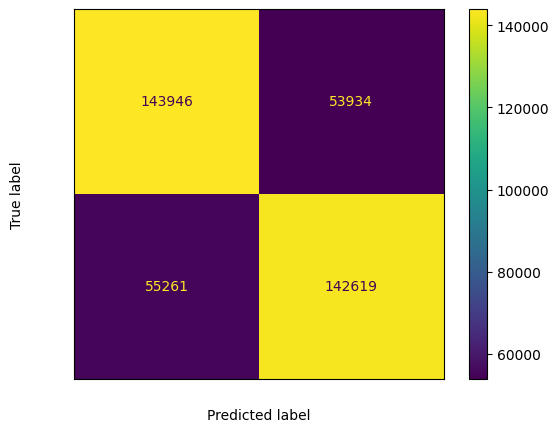

Accuracy =  0.7240878310086921
Precision =  0.7256007285566742
Recall =  0.7207347887608652
F1-score =  0.7231595733622693
RMSE =  0.5252734230772654


In [98]:
# param_grid = {'n_estimators':[300], 'max_depth':[5]}
# rf_param=GridSearchCV(RandomForestClassifier(), param_grid, cv = cv, verbose=3, scoring = 'recall')
# rf_param.fit(X_train[included].values, Y_train.values)
# best_parameters = rf_param.best_estimator_.get_params()
rd = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=1)
rd.fit(X_train[included], Y_train)

# make prediction
y_predict = rd.predict(X_train[included])
# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_train, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='white', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_train, y_predict))
print('Precision = ', metrics.precision_score(Y_train, y_predict))
print('Recall = ',metrics.recall_score(Y_train, y_predict))
print('F1-score = ', metrics.f1_score(Y_train, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_train, y_predict)))

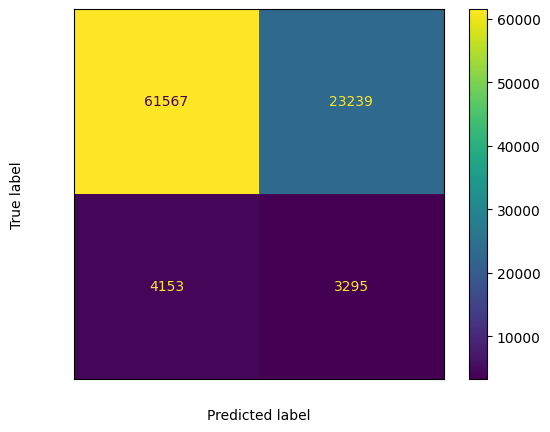

Accuracy =  0.7030806252303423
Precision =  0.12418029697746288
Recall =  0.4424006444683136
F1-score =  0.19392619622152904
RMSE =  0.5449030875024087


In [99]:
# make prediction
y_predict = rd.predict(X_test[included])

# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='white', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
print('Precision = ', metrics.precision_score(Y_test, y_predict))
print('Recall = ',metrics.recall_score(Y_test, y_predict))
print('F1-score = ', metrics.f1_score(Y_test, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_test, y_predict)))

<AxesSubplot:ylabel='feature'>

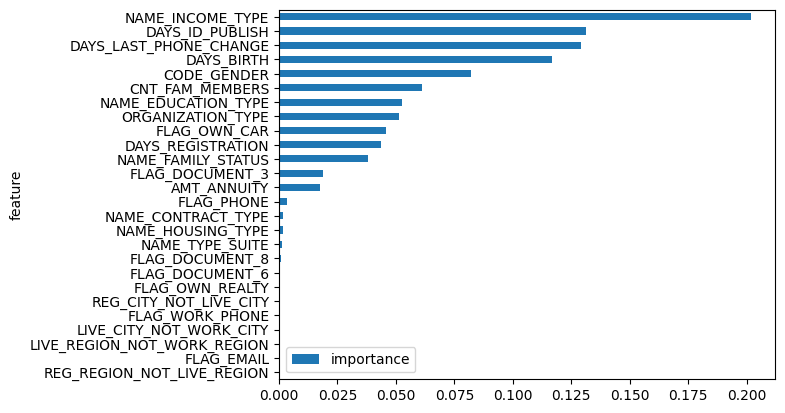

In [100]:
imp = rd.feature_importances_
feature = rd.feature_names_in_
df_imp = pd.DataFrame()
df_imp['feature'] = feature
df_imp['importance'] = imp
df_imp.set_index('feature', inplace=True)
df_imp.sort_values(ascending=True, by='importance').plot.barh()

## XGBoost

In [ ]:
import xgboost as xgb
def xgboost(X_train, y_train, X_test, Y_test, grid_search=False, draw=False):
    f1 = make_scorer(f1_score , average='macro')
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_train = y_train.astype('int')
    Y_test = Y_test.astype('int')
    #查看訓練情況
    eval_s = [(X_train, y_train),(X_test, Y_test)]
    eval_result = {}

    xgboost_model=xgb.XGBClassifier(eval_result = eval_result)
    xgboost_model.fit(X_train, y_train, eval_set = eval_s, eval_metric=["error", "logloss"])

    if grid_search==True:
    
        parameters = {'n_estimators': [1000,2000],'learning_rate': [0.01, 0.05],'max_depth': [3,5,7], 'min_child_weight':[1,2,3],'gamma':[2,3]}
        grid_param=GridSearchCV(xgboost_model, param_grid=parameters, scoring = 'accuracy', cv=cv)
        grid_param.fit(X_train,y_train)
        best_parameters = grid_param.best_estimator_.get_params()
        eval_result = {}
        xgboost_model=xgb.XGBClassifier(learning_rate=best_parameters['learning_rate'],n_estimators=best_parameters['n_estimators'],max_depth=best_parameters['max_depth'],
                                        min_child_weight=best_parameters['min_child_weight'],gamma=best_parameters['gamma'],eval_set = eval_s,eval_metric=["error", "logloss"])

        if draw == True:
            xgboost_model.fit(X_train,y_train)  
            feature_importance=xgboost_model.get_booster().get_score()
            keys = list(feature_importance.keys())
            values = list(feature_importance.values())
            data = pd.DataFrame(data=values, index=keys, 
            columns=["score"]).sort_values(by = "score", ascending=True)
            plt.figure() 
            ax = data.plot(kind='barh',figsize=(10,10),fontsize=18)
            ax.set_xlabel('features importance',fontsize=20)
            ax.set_ylabel('features name',fontsize=20)
            ax.set_title('feature importance',fontsize=20)
            plt.show()

     #train data
    y_predict = xgboost_model.predict(X_train)

    # plot confusion matirx
    confusion_matrix = metrics.confusion_matrix(y_train, y_predict)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.tick_params(colors='white', which='both')
    plt.show() 

    # print score
    print('Accuracy = ',metrics.accuracy_score(y_train, y_predict))
    print('Precision = ', metrics.precision_score(y_train, y_predict))
    print('Recall = ',metrics.recall_score(y_train, y_predict))
    print('F1-score = ', metrics.f1_score(y_train, y_predict))
    print('RMSE = ', np.sqrt(mean_squared_error(y_train, y_predict)))

    # #test data
    # y_predict = xgboost_model.predict(X_vad)

    # # plot confusion matirx
    # confusion_matrix = metrics.confusion_matrix(y_vad, y_predict)
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    # cm_display.plot()
    # plt.tick_params(colors='white', which='both')
    # plt.show() 

    # # print score
    # print('Accuracy = ',metrics.accuracy_score(y_vad, y_predict))
    # print('Precision = ', metrics.precision_score(y_vad, y_predict))
    # print('Recall = ',metrics.recall_score(y_vad, y_predict))
    # print('F1-score = ', metrics.f1_score(y_vad, y_predict))
    # print('RMSE = ', np.sqrt(mean_squared_error(y_vad, y_predict)))

    #predict data
    y_predict = xgboost_model.predict(X_test)

    # plot confusion matirx
    confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.tick_params(colors='white', which='both')
    plt.show() 

    # print score
    print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
    print('Precision = ', metrics.precision_score(Y_test, y_predict))
    print('Recall = ',metrics.recall_score(Y_test, y_predict))
    print('F1-score = ', metrics.f1_score(Y_test, y_predict))
    print('RMSE = ', np.sqrt(mean_squared_error(Y_test, y_predict)))

In [ ]:
xgboost(X_train[included], Y_train, X_test[included], Y_test, grid_search=True, draw=False)

[10:14:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_result" } are not used.

[0]	validation_0-error:0.32239	validation_0-logloss:0.64389	validation_1-error:0.38588	validation_1-logloss:0.64975
[1]	validation_0-error:0.27732	validation_0-logloss:0.60245	validation_1-error:0.27730	validation_1-logloss:0.61284
[2]	validation_0-error:0.25430	validation_0-logloss:0.57724	validation_1-error:0.24911	validation_1-logloss:0.59131
[3]	validation_0-error:0.24422	validation_0-logloss:0.55435	validation_1-error:0.24064	validation_1-logloss:0.57138
[4]	validation_0-error:0.22443	validation_0-logloss:0.53267	validation_1-error:0.23518	validation_1-logloss:0.55228
[5]	validation_0-error:0.21883	validation_0-logloss:0.51866	validation_1-error:0.23478	validation_1-logloss:0.54106
[6]	validation_0-error:0.18648	validation_0-logloss:0.47986	validation_1-error:0.19267	validation_1-logloss:0.50545
[7]

KeyboardInterrupt: 

## LGBM

In [115]:
# param_grid = {'learning_rate':[0.05,0.1],'n_estimators':[20,30,40],'num_leaves': [3,4,5],'bagging_fraction': [0.6, 0.7],'max_depth':[3, 5, 7],'reg_lambda':[0.3, 0.6],'min_child_weight':[7]}
# lgbm_param = GridSearchCV(LGBMClassifier(), param_grid, cv=cv, scoring='recall')
# lgbm_param = lgbm_param.fit(X_train[included], Y_train)
# best_para = lgbm_param.best_params_

# lgbm = LGBMClassifier(learning_rate = best_para['learning_rate'], n_estimators = best_para['n_estimators'], num_leaves = best_para['num_leaves'], bagging_fraction = best_para['bagging_fraction'], max_depth = best_para['max_depth'],
#                     reg_lambda = best_para['reg_lambda'], min_child_weight = best_para['min_child_weight'])
lgbm = LGBMClassifier()
lgbm = lgbm.fit(X_train[included], Y_train)
y_pred_grid = lgbm.predict(X_train[included])

confusion_matrix = metrics.confusion_matrix(Y_train, y_pred_grid)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='black', which='both')
plt.show()


print('Accuracy = ',metrics.accuracy_score(Y_train, y_pred_grid))
print('Precision = ', metrics.precision_score(Y_train, y_pred_grid))
print('Recall = ',metrics.recall_score(Y_train, y_pred_grid))
print('F1-score = ', metrics.f1_score(Y_train, y_pred_grid))

[LightGBM] [Warning] Unknown parameter: earning_rate
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[LightGBM] [Fatal] Number of classes must be 1 for non-multiclass training


LightGBMError: Number of classes must be 1 for non-multiclass training

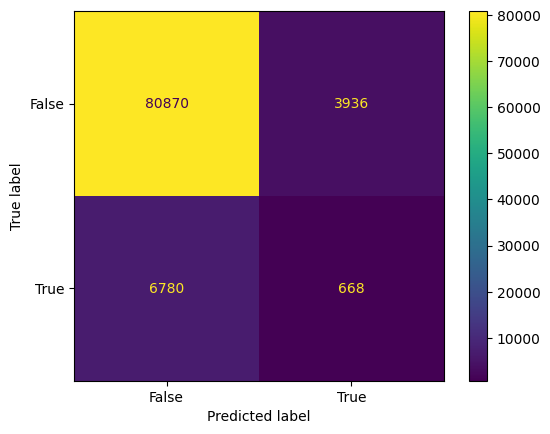

Accuracy =  0.8838424350163678
Precision =  0.14509122502172025
Recall =  0.08968850698174007
F1-score =  0.11085297046133423


In [113]:
y_pred_grid = lgbm.predict(X_test[included])

confusion_matrix = metrics.confusion_matrix(Y_test, y_pred_grid)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='black', which='both')
plt.show()


print('Accuracy = ',metrics.accuracy_score(Y_test, y_pred_grid))
print('Precision = ', metrics.precision_score(Y_test, y_pred_grid))
print('Recall = ',metrics.recall_score(Y_test, y_pred_grid))
print('F1-score = ', metrics.f1_score(Y_test, y_pred_grid))

In [ ]:
# # make prediction
# y_predict = clf_LGBM.predict(X_test[included2])

# # plot confusion matirx
# confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.plot()
# plt.tick_params(colors='black', which='both')
# plt.show() 
# # print score
# print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
# print('Precision = ', metrics.precision_score(Y_test, y_predict))
# print('Recall = ',metrics.recall_score(Y_test, y_predict))
# print('F1-score = ', metrics.f1_score(Y_test, y_predict))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

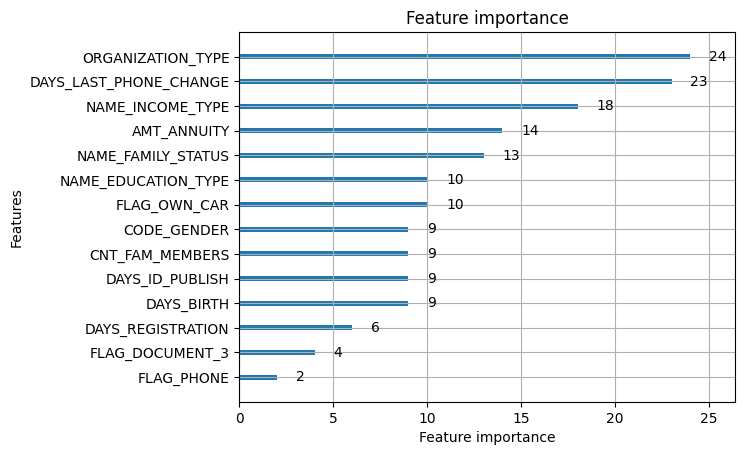

In [91]:
import lightgbm
lightgbm.plot_importance(lgbm, max_num_features=20)

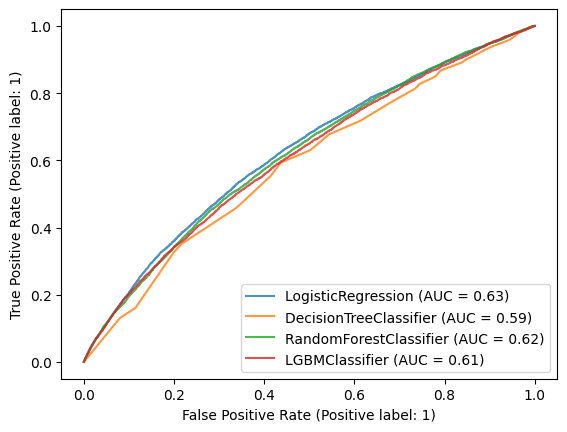

In [105]:
from sklearn.metrics import RocCurveDisplay

ax = plt.gca()
LR_disp = RocCurveDisplay.from_estimator(logistic_regression, X_test, Y_test, ax=ax, alpha=0.8)
DT_disp = RocCurveDisplay.from_estimator(dc, X_test[included], Y_test, ax=ax, alpha=0.8)
RF_disp = RocCurveDisplay.from_estimator(rd, X_test[included], Y_test, ax=ax, alpha=0.8)
LGBM_disp = RocCurveDisplay.from_estimator(lgbm, X_test[included], Y_test, ax=ax, alpha=0.8)